In [20]:
# ============================================================
# 🔧 CONFIGURATION
# ============================================================
import os, random, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # <-- add this
})

config = {
    "image_folder": "../../../SparseSamplingCS-AE-RL/data/faces/ai/",
    "image_size": 128,
    "batch_size": 32,
    "epochs": 30,
    "learning_rate": 1e-3,
    "latent_dim": 128,
    "train_split": 0.7,
    "val_split": 0.15,
    "num_workers": 2,
    "seed": 42
}

# ============================================================
# ⚙️ DEVICE SETUP
# ============================================================
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])

# ============================================================
# 📦 DATA
# ============================================================
transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(config["image_folder"], transform=transform)
n_total = len(dataset)
n_train = int(config["train_split"] * n_total)
n_val = int(config["val_split"] * n_total)
n_test = n_total - n_train - n_val

train_data, val_data, test_data = random_split(dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, num_workers=config["num_workers"])
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"])
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"])
print(f"Train: {n_train}, Val: {n_val}, Test: {n_test}")

# ============================================================
# 🧠 VARIATIONAL AUTOENCODER MODEL
# ============================================================
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # --- same encoder depth as your ConvAutoencoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        # flatten for μ and logσ²
        enc_out_dim = 128 * (config["image_size"] // 8) ** 2
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_out_dim, latent_dim)

        # decoder mirrors encoder
        self.fc_dec = nn.Linear(latent_dim, enc_out_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x).flatten(start_dim=1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, config["image_size"] // 8, config["image_size"] // 8)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# ============================================================
# 📉 LOSS + OPTIMIZER
# ============================================================
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kld) / x.size(0)

model = VAE(latent_dim=config["latent_dim"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# ============================================================
# 🏋️ TRAINING LOOP
# ============================================================
train_losses, val_losses = [], []
for epoch in range(config["epochs"]):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            recon, mu, logvar = model(imgs)
            loss = vae_loss(recon, imgs, mu, logvar)
            val_loss += loss.item() * imgs.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{config['epochs']} | Train {train_loss:.4f} | Val {val_loss:.4f}")



Using device: cuda
Train: 3241, Val: 694, Test: 695
Epoch 1/30 | Train 1455.8964 | Val 710.3950
Epoch 2/30 | Train 616.3993 | Val 540.2893
Epoch 3/30 | Train 523.1668 | Val 489.8182
Epoch 4/30 | Train 477.1532 | Val 459.5601
Epoch 5/30 | Train 445.3015 | Val 433.9358
Epoch 6/30 | Train 422.1413 | Val 416.8675
Epoch 7/30 | Train 402.4875 | Val 404.5614
Epoch 8/30 | Train 389.2433 | Val 421.5488
Epoch 9/30 | Train 373.9457 | Val 369.2952
Epoch 10/30 | Train 358.0645 | Val 376.6164
Epoch 11/30 | Train 347.4634 | Val 348.9651
Epoch 12/30 | Train 337.8221 | Val 348.0792
Epoch 13/30 | Train 329.1860 | Val 338.6299
Epoch 14/30 | Train 320.8200 | Val 333.9200
Epoch 15/30 | Train 313.4888 | Val 325.1113
Epoch 16/30 | Train 309.8878 | Val 319.5760
Epoch 17/30 | Train 300.1022 | Val 312.5874
Epoch 18/30 | Train 296.3381 | Val 307.7920
Epoch 19/30 | Train 292.0242 | Val 320.3125
Epoch 20/30 | Train 289.4361 | Val 299.8960
Epoch 21/30 | Train 282.3388 | Val 298.4338
Epoch 22/30 | Train 280.6262 | V

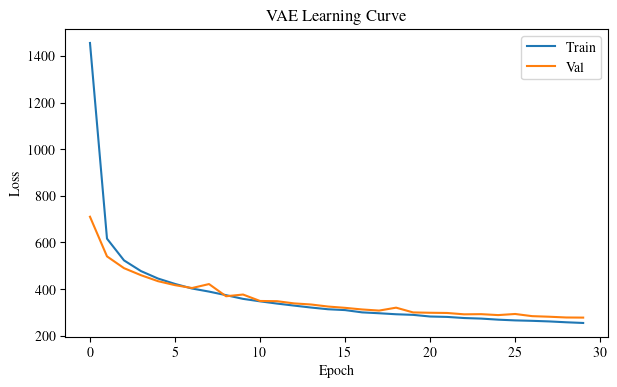

In [ ]:
# ============================================================
# LEARNING CURVE
# ============================================================
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("VAE Learning Curve")
plt.legend()
#plt.savefig("VAE-learningcurve.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

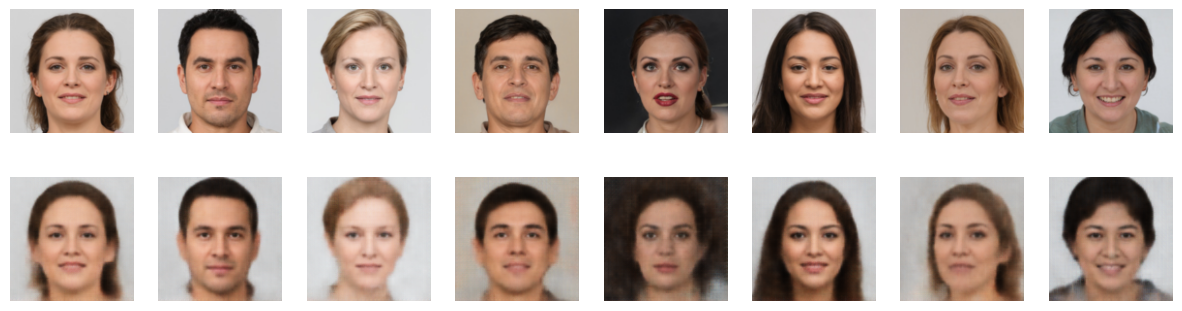

In [ ]:
# ============================================================
# RECONSTRUCTIONS
# ============================================================
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:8].to(device)
    recon, _, _ = model(imgs)
    imgs, recon = imgs.cpu(), recon.cpu()

fig, axes = plt.subplots(2, 8, figsize=(15,4))
for i in range(8):
    axes[0,i].imshow(np.transpose(imgs[i], (1,2,0))); axes[0,i].axis("off")
    axes[1,i].imshow(np.transpose(recon[i], (1,2,0))); axes[1,i].axis("off")
axes[0,0].set_ylabel("Original"); axes[1,0].set_ylabel("Reconstructed")
#plt.savefig("VAE-reconstruction.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

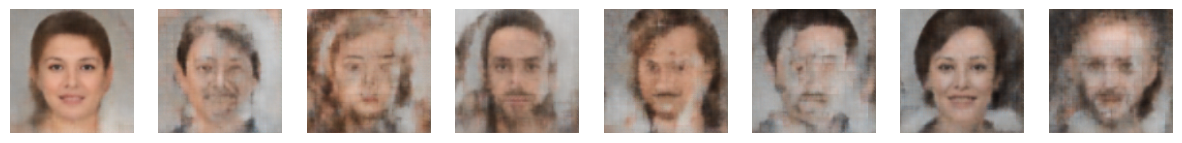

In [ ]:
# ============================================================
# SAMPLING FROM LATENT SPACE
# ============================================================
with torch.no_grad():
    z = torch.randn(8, config["latent_dim"]).to(device)
    samples = model.decode(z).cpu()

fig, axes = plt.subplots(1,8, figsize=(15,2))
for i in range(8):
    axes[i].imshow(np.transpose(samples[i], (1,2,0)))
    axes[i].axis("off")
#plt.suptitle("Random Samples from Latent Space")
#plt.savefig("VAE-randomsampling.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

Iter [1/1000]  Loss: 1.687602e-02
Iter [100/1000]  Loss: 4.082093e-03
Iter [200/1000]  Loss: 1.669360e-03
Iter [300/1000]  Loss: 1.051310e-03
Iter [400/1000]  Loss: 8.446067e-04
Iter [500/1000]  Loss: 7.516905e-04
Iter [600/1000]  Loss: 7.002887e-04
Iter [700/1000]  Loss: 6.671483e-04
Iter [800/1000]  Loss: 6.407630e-04
Iter [900/1000]  Loss: 6.202436e-04
Iter [1000/1000]  Loss: 6.032615e-04


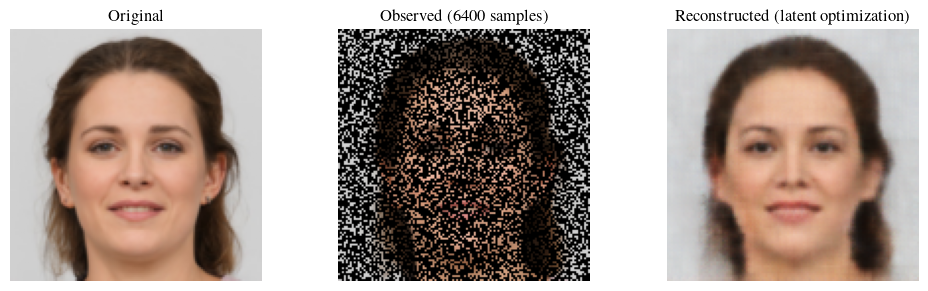

In [ ]:
# ============================================================
# VAE Sparse Reconstruction via Latent Optimization
# ============================================================
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    test_imgs, _ = next(iter(test_loader))
test_img = test_imgs[0:1].to(device)

# Number of sampled pixels
n_samples = 6400   # try 0, 10, 100, 1000, etc.
img_size = config["image_size"]

# ---- create 2D sampling mask ----
mask2d = torch.zeros((1, 1, img_size, img_size), device=device)
xy_idx = torch.randint(0, img_size * img_size, (n_samples,), device=device)
mask2d.view(-1)[xy_idx] = 1.0
mask = mask2d.repeat(1, 3, 1, 1)

# sparse measurement
measured = test_img * mask

# ---- initialize latent randomly ----
latent_dim = config["latent_dim"]
z = torch.randn(1, latent_dim, device=device, requires_grad=True)

optimizer_z = optim.Adam([z], lr=1e-2)
loss_fn = nn.MSELoss()

# ---- optimization loop ----
n_iters = 1000
for i in range(n_iters):
    optimizer_z.zero_grad()
    recon = model.decode(z)
    loss = loss_fn(recon * mask, measured)
    loss.backward()
    optimizer_z.step()

    if (i + 1) % 100 == 0 or i == 0:
        print(f"Iter [{i+1}/{n_iters}]  Loss: {loss.item():.6e}")

# ---- reconstruct final image ----
with torch.no_grad():
    recon_img = model.decode(z).cpu().squeeze(0)
    sparse_obs = measured.cpu().squeeze(0)
    orig = test_img.cpu().squeeze(0)

def to_img(t): return np.transpose(t.numpy(), (1, 2, 0))

# ---- visualization ----
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(to_img(orig))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(to_img(sparse_obs))
axes[1].set_title(f"Observed ({n_samples} samples)")
axes[1].axis("off")

axes[2].imshow(to_img(recon_img))
axes[2].set_title("Reconstructed (latent optimization)")
axes[2].axis("off")

plt.tight_layout()
#plt.savefig("VAE-SparseReconstruction6400.pdf", bbox_inches="tight", pad_inches=0)
plt.show()
